<a href="https://colab.research.google.com/github/rylan-berry/DataScienceExercises2025-2026/blob/main/RylaBerrU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analyzing Spongebob Viewership on Episode Release**

##Installs & Imports

In [2]:
!pip install preliz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 6.9 MB/s eta 0:00:00


In [3]:
import preliz as pz

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

##Context

Spongebob Squarepants is a popular TV series produced by Nickelodeon. The series is primarily a comedy aimed at kids. Lets quantify how popular espisodes are on average.

##Previous Knowledge



As a popular TV series, I think most of the viewership of the show will be around a decent range, before going down towards 0. This about describes a high variance, low kurtois, and right skew distribution. Important info, we're looking at how many people were watching when the episodes first went on air instead of constant viewership.

##Data and Data Collection

The data was gathered from www.kaggle.com, our dataset itself is at https://www.kaggle.com/datasets/myticalcat/spongebob-squarepants-episodes-dataset, and I also stored the dataset into github for ease of access. Moving on, the main focus from this dataset is the number of viewers when the episode airs. The data includes strings that explain a bit more about the data or to say we don't know anything about certain viewerships on episodes, so we scrubbed out anything that is a string that would be challengeing to convert into a number, and anything where the number is not listed. The data is also converted to be given as in terms of thousands instead of millions for the sake of the accuracy.

In [5]:
#I had gemini fix the URL since I didn't know you had to use a special github url
episode_data = pd.read_csv("https://raw.githubusercontent.com/rylan-berry/DataScienceExercises2025-2026/main/spongebob_episodes.csv")

In [6]:
raw_num_of_viewers = episode_data["U.S. viewers (millions)"]
#scrubs dataset of any hard to handle strings and any episodes that don't have listed viewer counts
errors = np.zeros_like(raw_num_of_viewers)
for i, num in enumerate(raw_num_of_viewers):
  try:
    n = float(num)
  except ValueError:
    errors[i] = 1
    continue
  if(np.isnan(n)):
    errors[i] = 1

num_of_viewers = raw_num_of_viewers.loc[errors == False]

#converts all remaining values to floats
num_of_viewers = num_of_viewers.apply(pd.to_numeric)
num_of_viewers

,U.S. viewers (millions)
0,2.96
1,2.96
2,2.96
3,2.51
4,2.51
...,...
568,0.20
569,0.18
570,0.18
571,0.16


In [7]:
num_of_viewers = num_of_viewers * 1000
num_of_viewers.name = "U.S. viewers (thousands)"
num_of_viewers

,U.S. viewers (thousands)
0,2960.0
1,2960.0
2,2960.0
3,2510.0
4,2510.0
...,...
568,200.0
569,180.0
570,180.0
571,160.0


(array([ 80.,  79.,  98., 110.,  95.,  57.,  29.,   7.,   2.,   2.]),
 array([  80.,  928., 1776., 2624., 3472., 4320., 5168., 6016., 6864.,
        7712., 8560.]),
 <BarContainer object of 10 artists>)

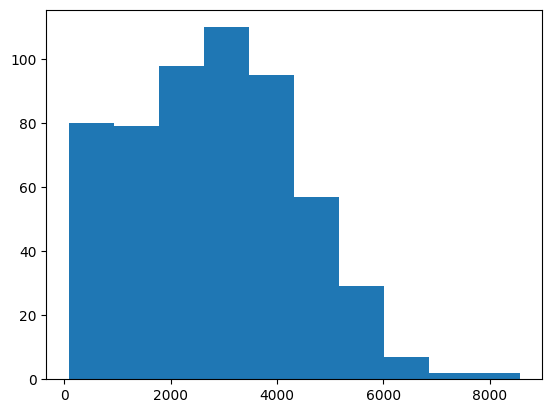

In [8]:
plt.hist(num_of_viewers)

##Likelyhood & Priors

After looking at the data, I believe a Negaitve Binomial looks like the data. We'll also use a Gamma since it's a basic distribution from 0 to infinity. I think the mean should be arround 3000, and the number needs to be above zero, so a Gamma is pretty good for both of the functions. I think the variance will be small, which is where having a low alpha comes in, so I just reused the Gamma and gave it a mean of about two for the Negative Binomial.

<Axes: >

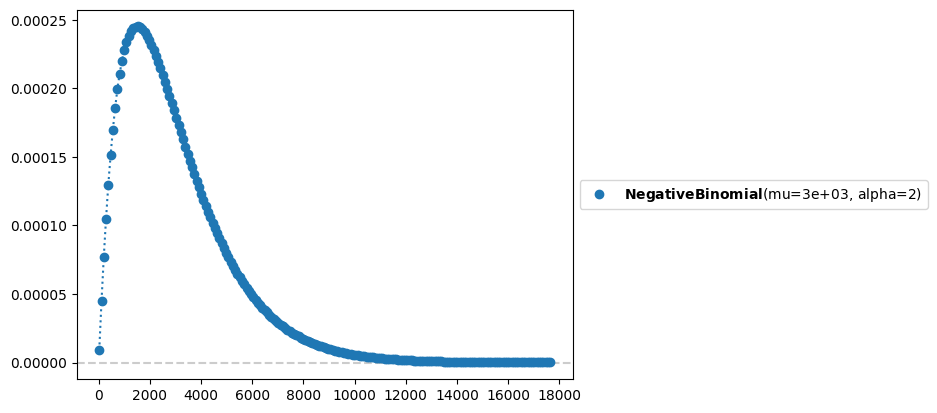

In [9]:
#Likelyhood 1
pz.NegativeBinomial(mu=3000, alpha=2).plot_pdf()

<Axes: >

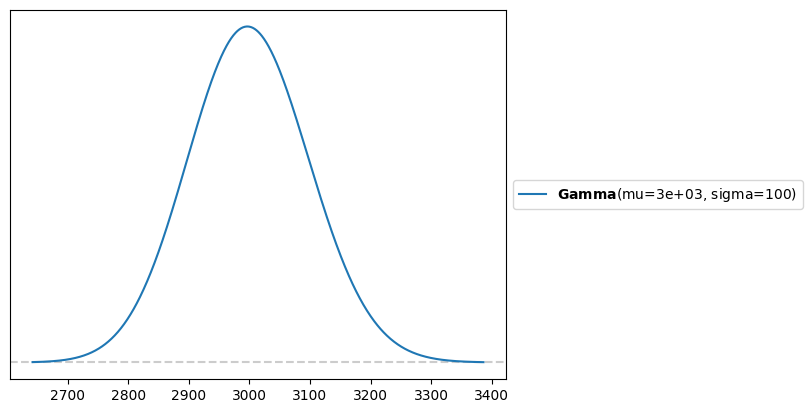

In [10]:
#Likelyhood 2
pz.Gamma(mu = 3000, sigma = 100).plot_pdf()

<Axes: >

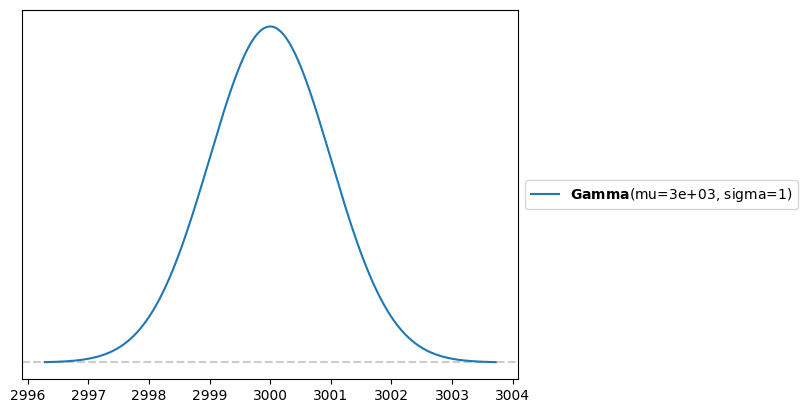

In [11]:
#Prior for the mu of likelyhood 1
pz.Gamma(mu = 3000, sigma = 1).plot_pdf()

<Axes: >

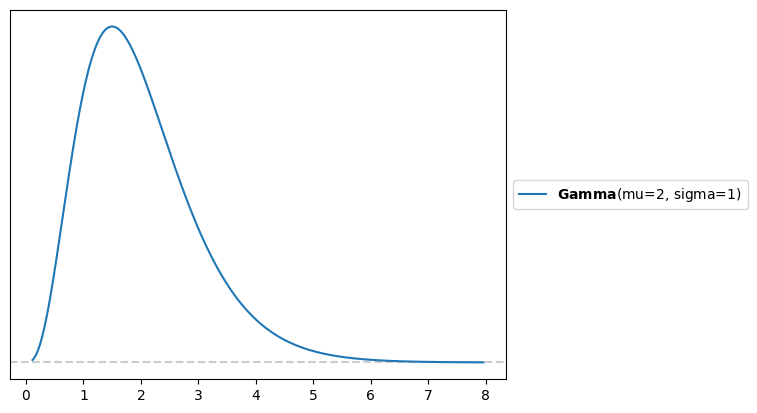

In [12]:
#Prior for the alpha of likelyhood 1
pz.Gamma(mu = 2, sigma = 1).plot_pdf()

<Axes: >

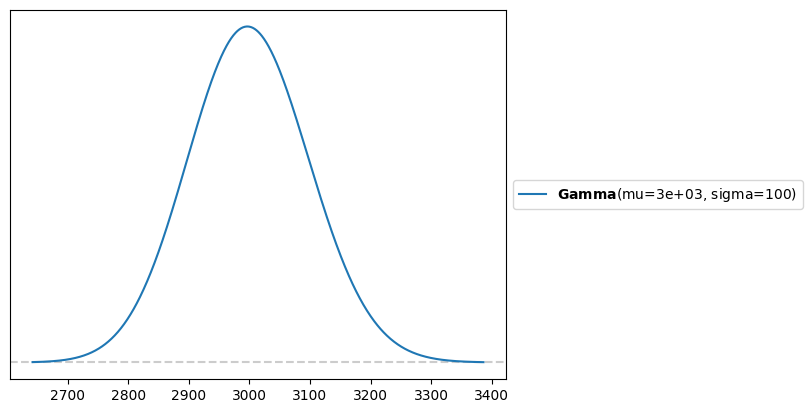

In [13]:
#Prior for the mu of the likelyhood 2
pz.Gamma(mu = 3000, sigma = 100).plot_pdf()

<Axes: >

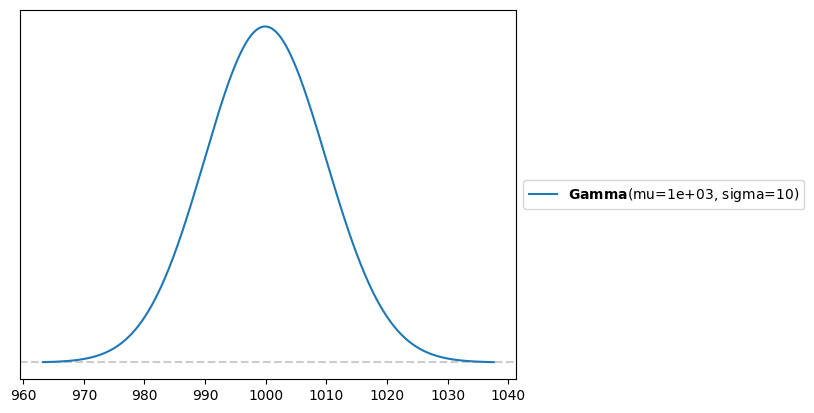

In [23]:
#Prior for the sigma of likelyhood 2
pz.Gamma(mu = 1000, sigma = 10).plot_pdf()

##Negative Binomial Model

In [ ]:
with pm.Model() as viewer_model_NB:

  μ = pm.Gamma("mu", mu=3000.0, sigma=1.0)
  α = pm.Gamma("alpha", mu=2.0, sigma=1.0)

  y1 = pm.NegativeBinomial("y1", mu = μ, alpha = α, observed = num_of_viewers)

  sample_data_NB = pm.sample()

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'mu'}>],
      dtype=object)

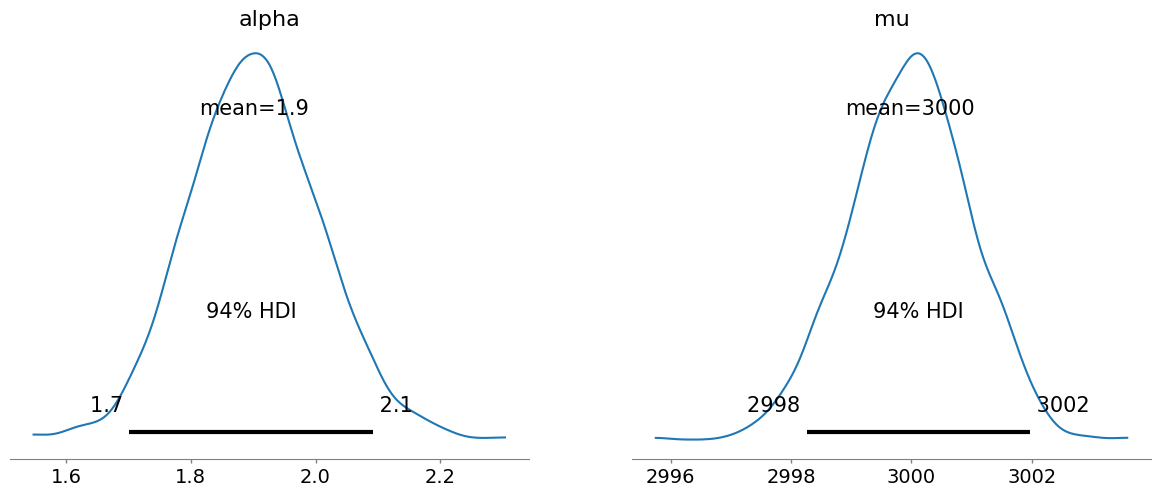

In [16]:
az.plot_posterior(sample_data_NB)

In [ ]:
pm.sample_posterior_predictive(sample_data_NB, model=viewer_model_NB, extend_inferencedata=True)

<Axes: xlabel='y1'>

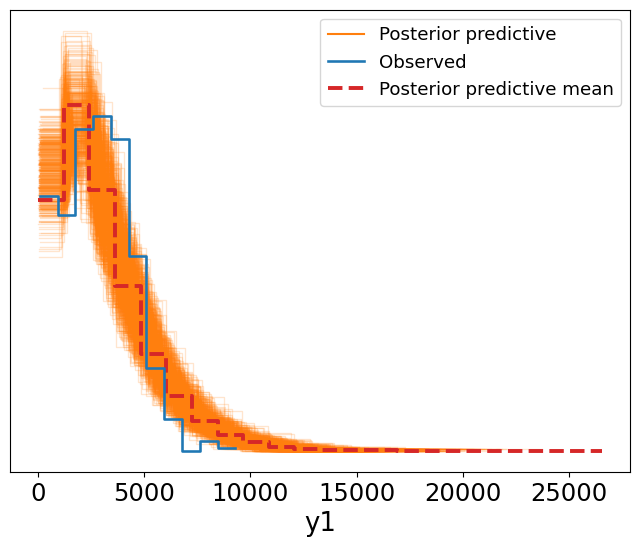

In [18]:
az.plot_ppc(sample_data_NB, num_pp_samples=500, figsize=(8, 6), colors=["C1", "C0", "C3"])

##Gamma Model

In [ ]:
with pm.Model() as viewer_model_G:

  μ = pm.Gamma("mu", mu=3000.0, sigma=100.0)
  sig = pm.Gamma("sigma", mu=1000.0, sigma=10.0)

  y2 = pm.Gamma("y2", mu = μ, sigma = sig, observed = num_of_viewers)

  sample_data_G = pm.sample()

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

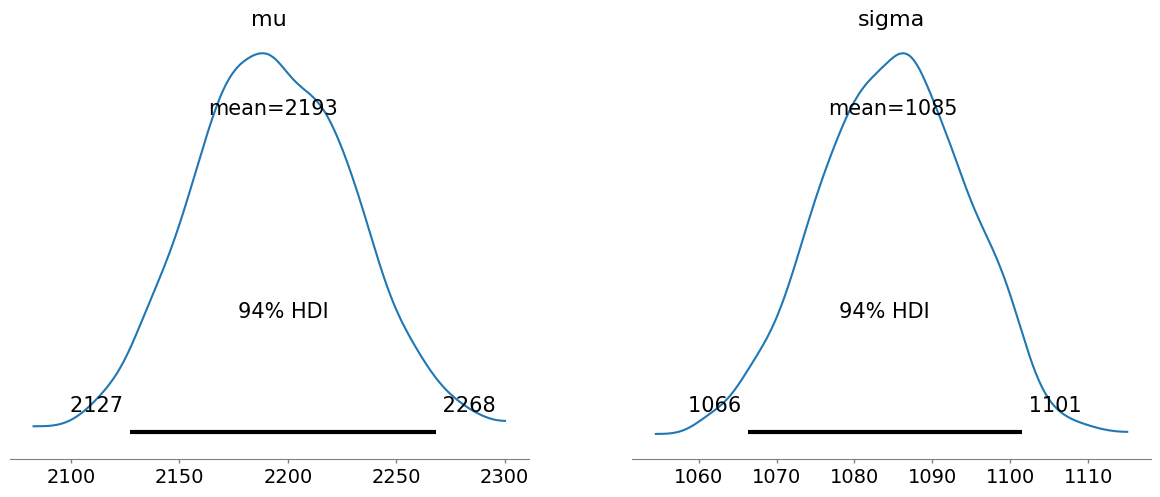

In [20]:
az.plot_posterior(sample_data_G)

In [ ]:
pm.sample_posterior_predictive(sample_data_G, model=viewer_model_G, extend_inferencedata=True)

<Axes: xlabel='y2'>

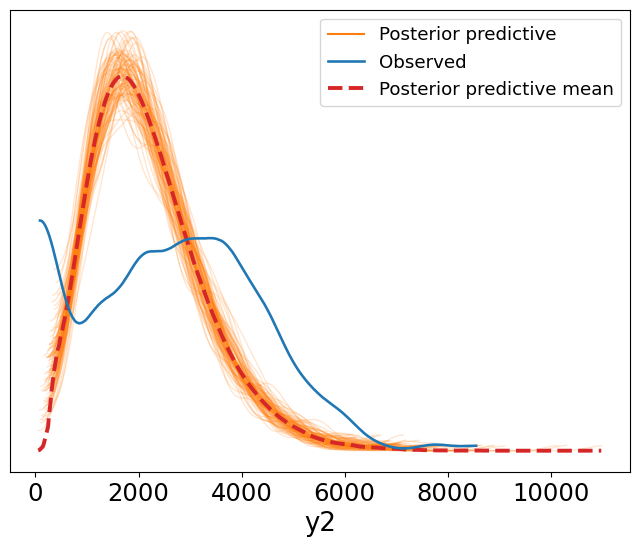

In [22]:
az.plot_ppc(sample_data_G, num_pp_samples=100, figsize=(8, 6), colors=["C1", "C0", "C3"])

##Conclusion

Based on the preformance of the two models, the ngeative binomial model has preformed better than the Gamma model. Both seem to match the mean, and both seem to have a right skew, but that's where the similarities end. The Gamma model barely matches the data. The peak is much more pointy than the data, and the variance seems to be lower than what it should be. In comparison, the negatie binomial seems to fit the data much better. There appears to be a pretty low variance (which seems to match the data). However, I don't know if the kurtosis matches very well, but that's likely due to me not entirely understanding what the look of the data meant. Besides that, the more acurate negative binomial model is telling us that most Spongebob episodes will get about 2-3 million viewers on release, there's a good possibility they get lower, and unlikely to get much higher of a viewership. So overall, Spongebob episodes are pretty popular.